In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
import umap
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from pytorch_metric_learning import losses

In [58]:
# Set global parameters
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(device)

mps


In [68]:
# Load and preprocess CIFAR10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load the training and test datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define the size for the train and validation splits
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the training dataset into training and validation sets
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders for training, validation, and test
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Help functions

### Training function

In [71]:
# Training function with validation
def train(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        # Calculate average losses
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        # Append to lists
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Print training and validation loss
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Plot training and validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), train_losses, color='red', marker='o', label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, color='blue', marker='s', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss vs. Epoch')
    plt.legend()
    plt.show()

    return train_losses, val_losses

### Test function

In [61]:
# Test the model with original test data
def test_model(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    losses = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            losses.append(loss.item())

    accuracy = 100 * correct / total
    print(f"Accuracy on original test data: {accuracy:.2f}%")

    # Plotting the test loss
    y_min = 0.0
    y_max = 8.0
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Test Loss')
    plt.title('Test Loss per batch')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.ylim(y_min, y_max)
    plt.legend()
    plt.show()

# Test the model with adversarial test data
def test_model_adversarial(model, adversarial_images, labels, criterion, device):
    model.eval()
    adversarial_dataset = torch.utils.data.TensorDataset(torch.tensor(adversarial_images), torch.tensor(labels))
    adversarial_dataloader = torch.utils.data.DataLoader(adversarial_dataset, batch_size=128, shuffle=False)

    correct = 0
    total = 0
    adversarial_test_loss = 0.0
    adversarial_losses = []

    with torch.no_grad():
        for images, labels in adversarial_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            adversarial_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            adversarial_losses.append(loss.item())

    accuracy = 100 * correct / total
    print(f"Accuracy on adversarial test data: {accuracy:.2f}%")

    # Plotting the adversarial test loss
    y_min = 0.0
    y_max = 8.0
    plt.figure(figsize=(10, 5))
    plt.plot(adversarial_losses, label='Adversarial Test Loss')
    plt.title('Adversarial Test Loss per batch')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.ylim(y_min, y_max)
    plt.legend()
    plt.show()

### KNN test function

In [62]:
# Extract features from the images using the pre-trained model
def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.cuda()
            features_batch = model(images).cpu().numpy()
            features.append(features_batch)
            labels.append(targets.numpy())
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels



# Test the model on original test data using KNN
def test_model_knn(model, knn_classifier, dataloader):
    model.eval()
    features, labels = extract_features(model, dataloader)
    predicted_labels = knn_classifier.predict(features)
    accuracy = accuracy_score(labels, predicted_labels) * 100
    print(f"Accuracy on original test data using KNN: {accuracy:.2f}%")



# Test the model on adversarial test data using KNN
def test_model_adversarial_knn(model, knn_classifier, adversarial_images, labels, device):
    model.eval()
    # Convert adversarial_images to PyTorch tensor and move it to the device
    adversarial_images_tensor = torch.tensor(adversarial_images, dtype=torch.float32).to(device)
    # Detach the tensor from the computation graph before calling .numpy()
    features = model(adversarial_images_tensor).detach().cpu().numpy()
    predicted_labels = knn_classifier.predict(features)
    accuracy = accuracy_score(labels, predicted_labels) * 100
    print(f"Accuracy on adversarial test data using KNN: {accuracy:.2f}%")

### Visualize feature map

In [63]:
def extract_and_visualize_features(model, images, labels, device):
    # Extract features from the second last layer of ResNet18
    feature_extractor = nn.Sequential(*list(model.children())[:-1])
    feature_extractor = feature_extractor.to(device)
    feature_extractor.eval()

    # Extract features for each image
    adversarial_features = []
    for image in images:
        image = torch.tensor(image, dtype=torch.float32).to(device)
        image = image.unsqueeze(0)  # Add an extra dimension for batch size
        features = feature_extractor(image).detach().cpu().numpy()
        adversarial_features.append(features)

    adversarial_features = np.concatenate(adversarial_features)

    # Visualize the features using UMAP
    umap_reducer = umap.UMAP(n_components=2)
    umap_features = umap_reducer.fit_transform(adversarial_features.reshape(adversarial_features.shape[0], -1))

    # Plot UMAP visualization
    plt.figure(figsize=(8, 6))
    plt.scatter(umap_features[:, 0], umap_features[:, 1], c=labels, cmap='viridis')
    plt.colorbar(label='Class')
    plt.title('UMAP Visualization of Adversarial Features')
    plt.show()


# 1. Train on original dataset/Cross Entropy
### 1.1. Generate adverserial samples with FGSM

/Users/homemac/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/homemac/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Training Loss: 0.9302, Validation Loss: 0.7598
Epoch [2/10], Training Loss: 0.5970, Validation Loss: 0.6427
Epoch [3/10], Training Loss: 0.4598, Validation Loss: 0.7069
Epoch [4/10], Training Loss: 0.3570, Validation Loss: 0.6437
Epoch [5/10], Training Loss: 0.2837, Validation Loss: 0.7090
Epoch [6/10], Training Loss: 0.2206, Validation Loss: 0.7475
Epoch [7/10], Training Loss: 0.1753, Validation Loss: 0.7645
Epoch [8/10], Training Loss: 0.1458, Validation Loss: 0.7755
Epoch [9/10], Training Loss: 0.1189, Validation Loss: 0.7816
Epoch [10/10], Training Loss: 0.1035, Validation Loss: 0.7542


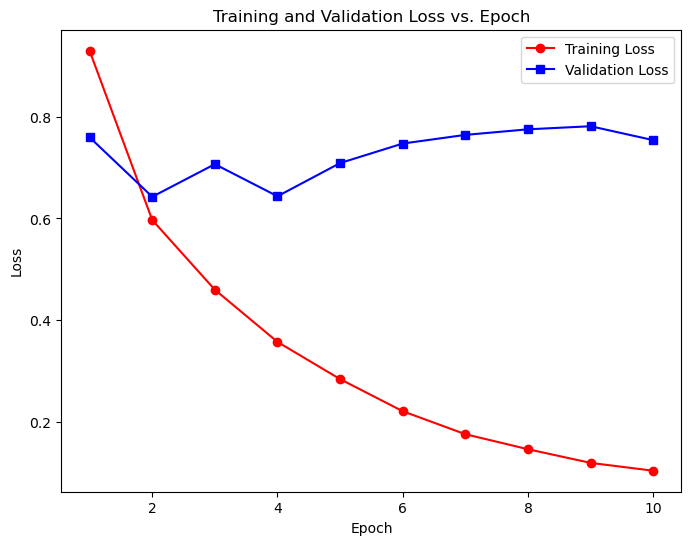

In [73]:
# Setup
model = resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train
train_losses = train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs)

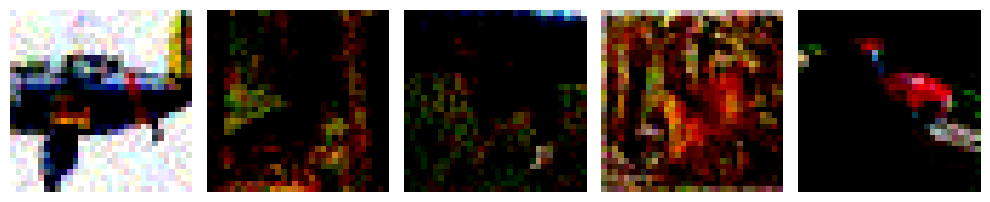

In [74]:
def combine_fgsm_and_noise(model, images, labels, eps, noise_factor):
    # Generate adversarial images using CleverHans's Fast Gradient Sign Method (FGSM)
    attack_images = fast_gradient_method(model, images, eps, np.inf, targeted=False, y=labels)

    # Detach the images to prevent further gradient computation
    attack_images = attack_images.detach()

    # Convert images to numpy to add noise
    attack_images_np = attack_images.cpu().numpy()

    # Add Gaussian noise
    attack_images_np += noise_factor * np.random.normal(loc=0, scale=1, size=attack_images_np.shape)
    attack_images_np = np.clip(attack_images_np, 0, 1)

    # Convert back to torch tensor
    attack_images_with_noise = torch.tensor(attack_images_np, requires_grad=False).to(device)

    return attack_images_with_noise

# Parameters for FGSM and noise
eps = 0.1
noise_factor = 0.05

model.eval()
adversarial_images = []
original_images = []
labels = []

for images, targets in val_loader:
    images, targets = images.to(device), targets.to(device)
    # Use the new combined function
    images_with_attack = combine_fgsm_and_noise(model, images, targets, eps, noise_factor).detach().cpu().numpy()
    adversarial_images.append(images_with_attack)
    original_images.append(images.detach().cpu().numpy())
    labels.append(targets.detach().cpu().numpy())

# Convert lists to numpy arrays
adversarial_images = np.concatenate(adversarial_images)
original_images = np.concatenate(original_images)
labels = np.concatenate(labels)

# Display some adversarial images
num_images = 5
indices = np.random.choice(len(adversarial_images), num_images, replace=False)
plt.figure(figsize=(10, 4))
for i, index in enumerate(indices):
    plt.subplot(1, num_images, i+1)
    plt.imshow(np.transpose(adversarial_images[index], (1, 2, 0)))
    plt.axis('off')
plt.tight_layout()
plt.show()

### 1.2. Test original data/Cross entropy

In [75]:
train_features, train_labels = extract_features(model, train_loader)

# Train KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_features, train_labels)

test_model_knn(model, knn_classifier, test_loader)
test_model_adversarial_knn(model, knn_classifier, adversarial_images, labels, device)

AssertionError: Torch not compiled with CUDA enabled

Accuracy on original test data: 80.53%


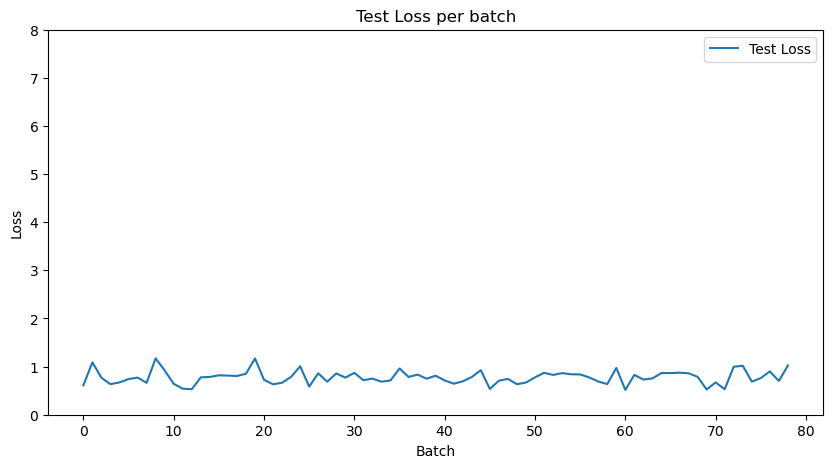

Accuracy on adversarial test data: 10.49%


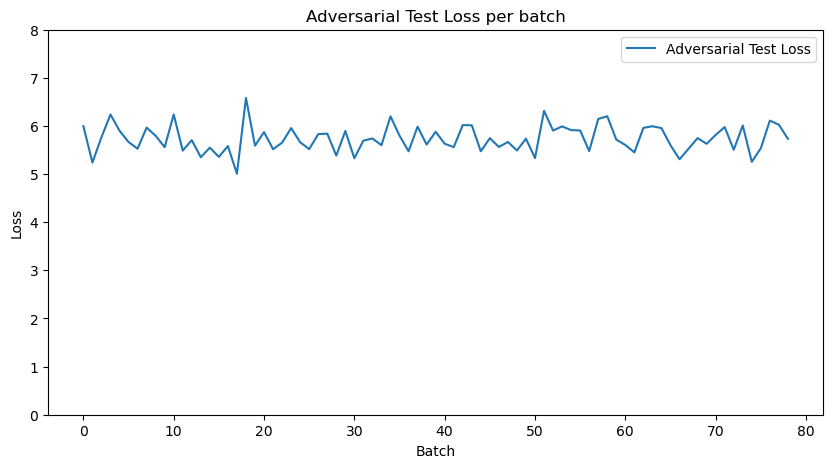

In [77]:
# Test the model on original test data
test_model(model, test_loader, criterion, device)

# Test the model on adversarial test data
test_model_adversarial(model, adversarial_images, labels, criterion, device)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


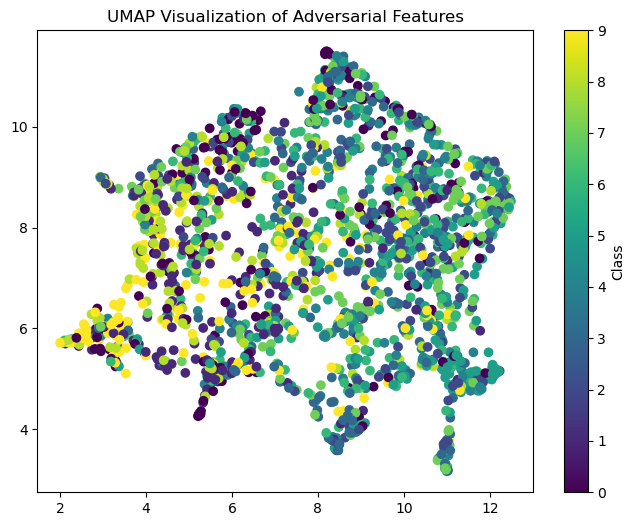

In [15]:
# Call the function to extract and visualize features
extract_and_visualize_features(model, adversarial_images, labels, device)

# 2. Train on agumented data/Cross entropy

In [80]:
# Function to apply FGSM attack with 50% probability to each batch
def apply_fgsm(model, images, labels, criterion, eps):
    # Enable gradients for images
    images.requires_grad = True

    # Perform FGSM attack only if gradients are enabled
    if images.requires_grad:
        outputs = model(images)
        model.zero_grad()
        cost = criterion(outputs, labels)
        cost.backward()
        attack_images = images + eps * images.grad.sign()
        attack_images = torch.clamp(attack_images, 0, 1)
    else:
        attack_images = images

    return attack_images

# Modified training function to apply FGSM with 50% probability
def train_with_fgsm(model, train_loader, val_loader, criterion, optimizer, device, epochs, eps=0.1):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_epoch_loss = 0.0
        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # Apply FGSM attack with 50% probability
            if torch.rand(1) < 0.5:
                images = apply_fgsm(model, images, labels, criterion, eps)

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_epoch_loss += loss.item()
        train_epoch_loss /= len(train_loader)
        train_losses.append(train_epoch_loss)

        # Validation loop
        model.eval()
        val_epoch_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Note: No FGSM attack is applied during validation
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_epoch_loss += loss.item()
        val_epoch_loss /= len(val_loader)
        val_losses.append(val_epoch_loss)

        # Print training and validation loss
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}")

    # Plot training and validation loss
    plt.figure(figsize=(10, 8))
    plt.plot(range(1, epochs + 1), train_losses, 'o-', label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, 's-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss vs. Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

    return train_losses, val_losses

In [81]:
# Setup and Retrain
new_model = resnet18(pretrained=True)
num_features = new_model.fc.in_features
new_model.fc = nn.Linear(num_features, 10)
new_model = new_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(new_model.parameters(), lr=0.001)

# Train
train_losses = train_with_fgsm(new_model, train_loader, val_loader, criterion, optimizer, device, num_epochs)

/Users/homemac/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/homemac/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 2.1. Test agumented data/Cross entropy

Accuracy on original test data: 77.94%


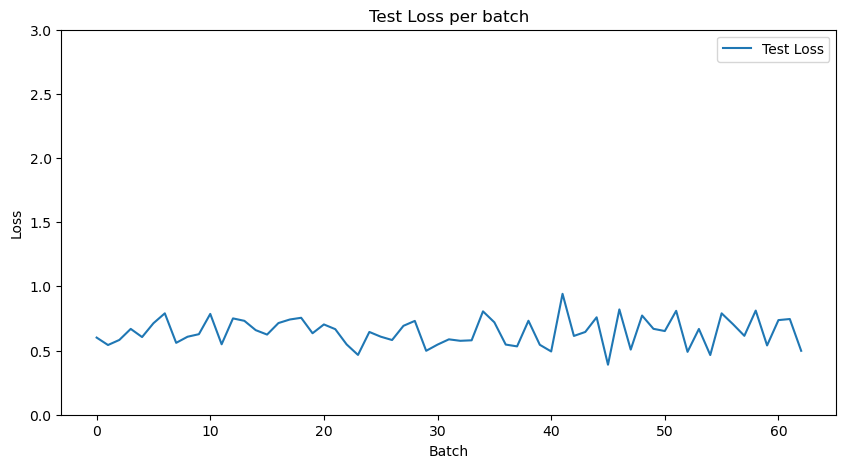

Accuracy on adversarial test data: 40.00%


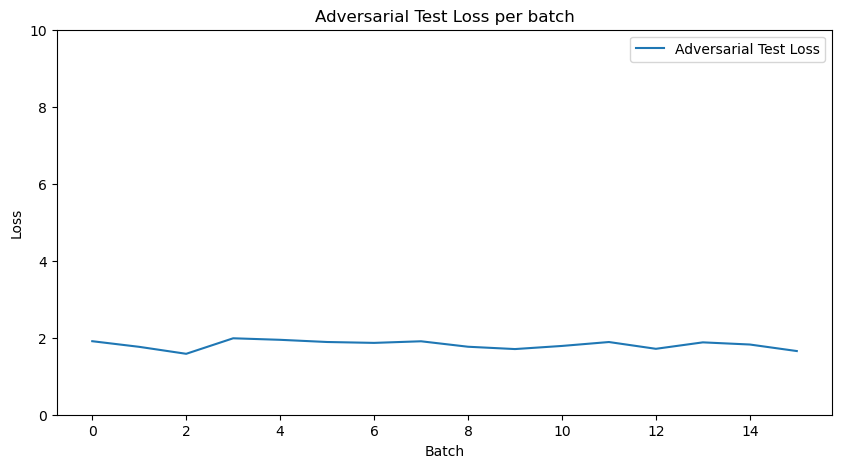

In [18]:
# Test the new model on original test data
test_model(new_model, test_loader, criterion, device)

# Test the new model on adversarial test data
test_model_adversarial(new_model, adversarial_images, labels, criterion, device)

In [19]:
# KNN test
train_features, train_labels = extract_features(new_model, train_loader)

# Train KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_features, train_labels)

test_model_knn(new_model, knn_classifier, test_loader)
test_model_adversarial_knn(new_model, knn_classifier, adversarial_images, labels, device)

AssertionError: Torch not compiled with CUDA enabled

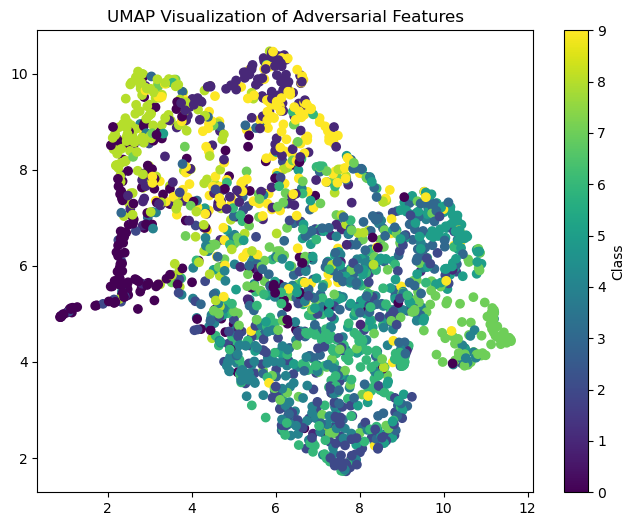

In [20]:
# Call the function to extract and visualize features
extract_and_visualize_features(new_model, adversarial_images, labels, device)

# 3. Train on original data/Circle loss

Epoch [1/10], Loss: 2.9985
Epoch [2/10], Loss: 1.4259
Epoch [3/10], Loss: 1.0121
Epoch [4/10], Loss: 0.7946
Epoch [5/10], Loss: 0.6537
Epoch [6/10], Loss: 0.5658
Epoch [7/10], Loss: 0.5226
Epoch [8/10], Loss: 0.4523
Epoch [9/10], Loss: 0.3918
Epoch [10/10], Loss: 0.3542


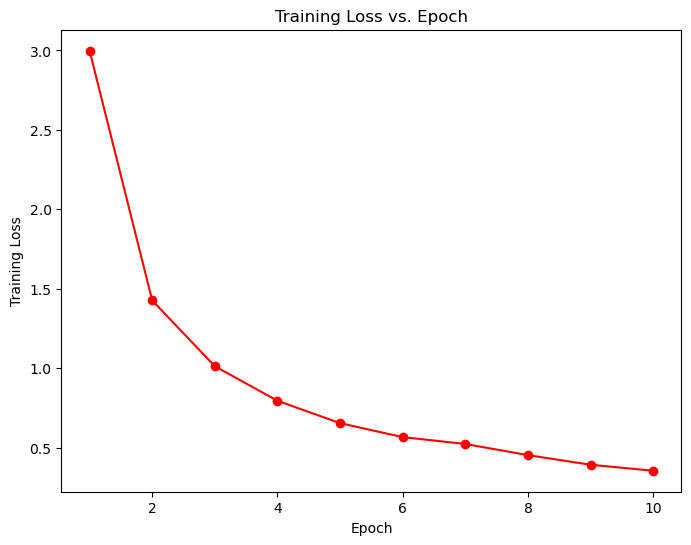

In [56]:
# Setup and Retrain
new_model2 = resnet18(pretrained=True)
num_features = new_model2.fc.in_features
new_model2.fc = nn.Linear(num_features, 10)
new_model2 = new_model2.to(device)

criterion = losses.CircleLoss(m=0.7, gamma=50)
optimizer = optim.Adam(new_model2.parameters(), lr=0.001)

# Train
train_losses_circle = train(new_model2, train_loader,criterion, optimizer, device, num_epochs)

### 3.1. Test agumented data/Cross entropy

Accuracy on original test data: 3.71%


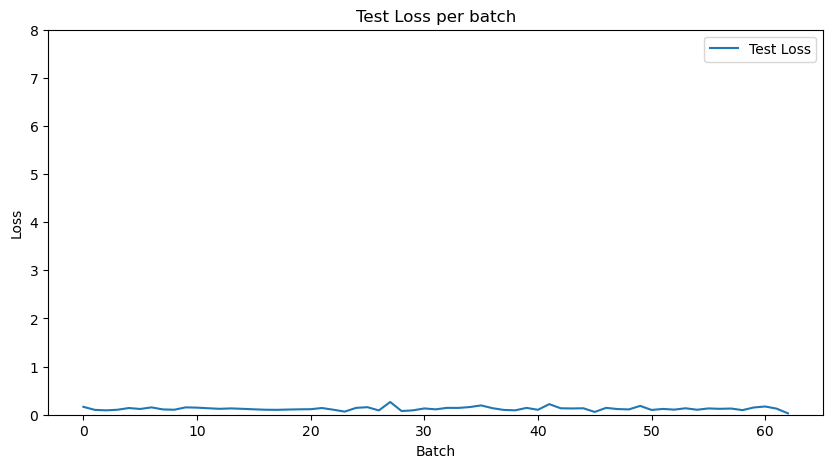

Accuracy on adversarial test data: 11.45%


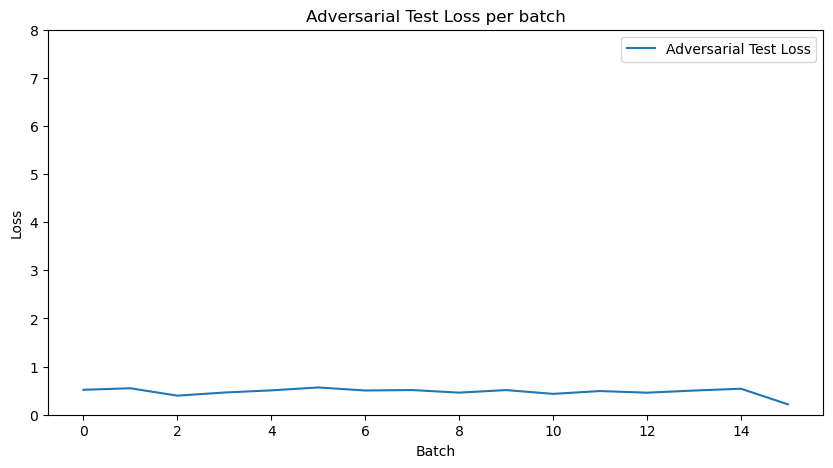

In [52]:
# Test the new model on original test data
test_model(new_model2, test_loader, criterion, device)

# Test the new model on adversarial test data
test_model_adversarial(new_model2, adversarial_images, labels, criterion, device)

In [ ]:
# KNN test
train_features, train_labels = extract_features(new_model2, train_loader)

# Train KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_features, train_labels)


test_model_knn(new_model2, knn_classifier, test_loader)
test_model_adversarial_knn(new_model2, knn_classifier, adversarial_images, labels, device)

AssertionError: Torch not compiled with CUDA enabled